## Descripción del Dataset
Se trata de un conjunto de datos de la NASA que estudia superficies aerodinámicas "NACA 0012" de diferentes tamaños y las pone a prueba en un túnel de viento a varias velocidades y diferentes ángulos de ataque. El tramo del perfil aerodinámico y la posición del observador fueron los mismos en todos los experimentos. Contiene un total de 6 atributos:

Entrada:

1. Frecuencia, en hercios.
2. Ángulo de ataque, en grados.
3. Longitud de la cuerda, en metros.
4. Velocidad de flujo libre, en metros por segundo.
5. Espesor de desplazamiento del lado de succión, en metros.

Salida (nuestro objetivo en la regresión):

6. Nivel de presión sonora, en decibelios.

## Importación de librerías

In [1]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

## Descarga de datos
Obtenemos el set de datos al que vamos a aplicar la regresión

In [2]:
url='https://drive.google.com/file/d/1wGQKWJPSP4BTIkBNl60WR0G82nZOmoAK/view?usp=sharing'
url2='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url2)
df

,Frecuency_Hz,Angle,Chord_length,Free_stream_velocity,Suction_side_displacement_thickness,Scaled_sound_pressure_level
0,1000,0.0,0.3048,71.3,0.002663,125.201
1,1250,0.0,0.3048,71.3,0.002663,125.951
2,1600,0.0,0.3048,71.3,0.002663,127.591
3,2000,0.0,0.3048,71.3,0.002663,127.461
4,2500,0.0,0.3048,71.3,0.002663,125.571
...,...,...,...,...,...,...
1497,2500,15.6,0.1016,39.6,0.052849,110.264
1498,3150,15.6,0.1016,39.6,0.052849,109.254
1499,4000,15.6,0.1016,39.6,0.052849,106.604
1500,5000,15.6,0.1016,39.6,0.052849,106.224


Comprobamos si contiene valores desconocidos

In [3]:
df.isna().sum()

Frecuency_Hz                           0
Angle                                  0
Chord_length                           0
Free_stream_velocity                   0
Suction_side_displacement_thickness    0
Scaled_sound_pressure_level            0
dtype: int64

No existen valores desconocidos

In [4]:
df.describe()

,Frecuency_Hz,Angle,Chord_length,Free_stream_velocity,Suction_side_displacement_thickness,Scaled_sound_pressure_level
count,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000
mean,2887.769640,6.786818,0.136436,50.847137,0.011146,124.835034
std,3153.162983,5.917509,0.093471,15.569029,0.013153,6.900864
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.190000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.719000
75%,4000.000000,9.900000,0.228600,71.300000,0.015840,129.997750
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


### Datos de entrenamiento y datos de prueba

Dividimos los datos en un 80% de entrenamiento y 20% de prueba

In [8]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

### Distribución de los datos

Gráfico con la distribución de los datos en cada atributo

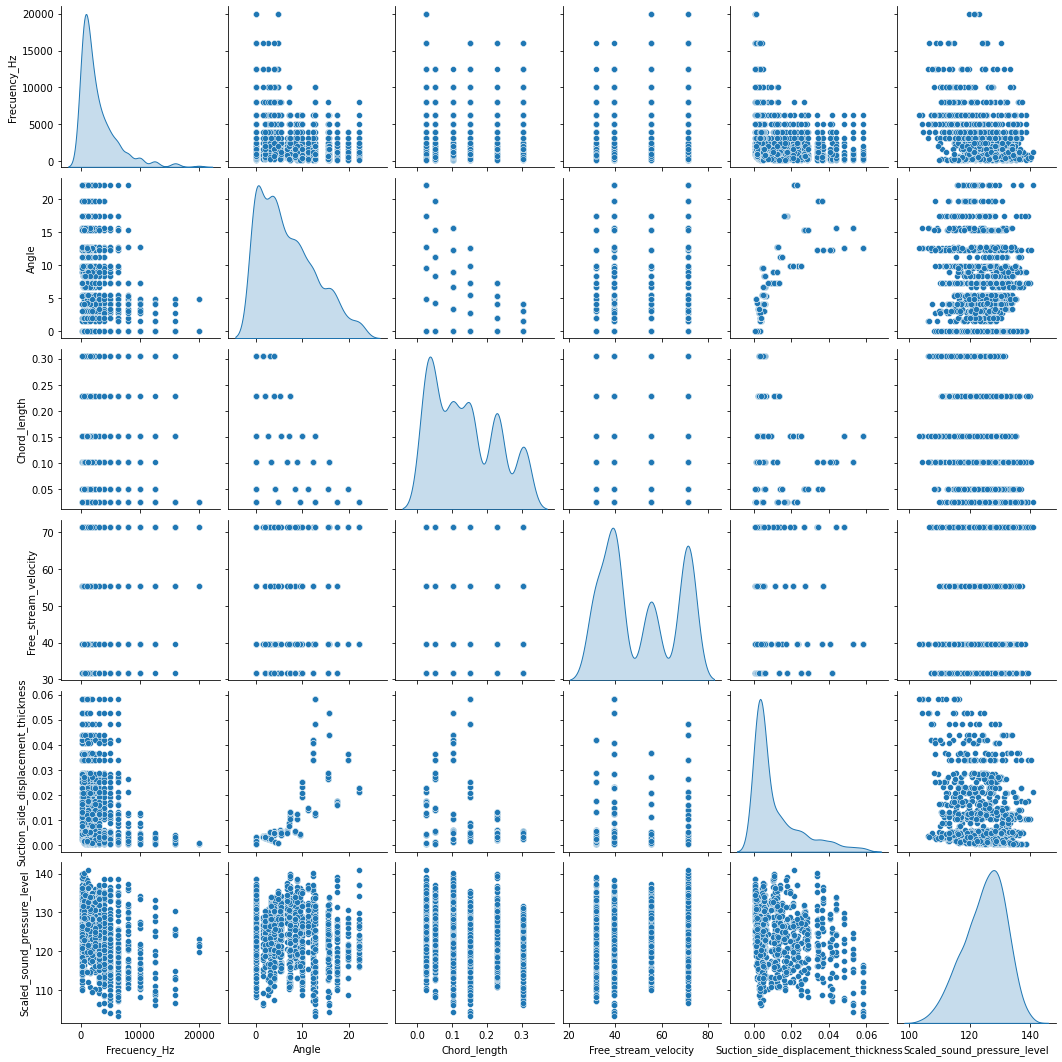

In [9]:
sns.pairplot(train_dataset[["Frecuency_Hz","Angle","Chord_length","Free_stream_velocity","Suction_side_displacement_thickness","Scaled_sound_pressure_level"]], diag_kind="kde")

Estadísticas de los datos de entrenamiento:

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("Scaled_sound_pressure_level")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Frecuency_Hz,1202.0,2888.718802,3174.132134,200.000000,800.000000,1600.000000,4000.000000,20000.000000
Angle,1202.0,6.805574,5.978301,0.000000,2.000000,5.400000,9.900000,22.200000
Chord_length,1202.0,0.136234,0.092524,0.025400,0.050800,0.101600,0.228600,0.304800
Free_stream_velocity,1202.0,50.789101,15.568757,31.700000,39.600000,39.600000,71.300000,71.300000
Suction_side_displacement_thickness,1202.0,0.011199,0.013182,0.000401,0.002514,0.004957,0.016104,0.058411


### Excluir el objetivo de los datos

El modelo se encargará de predecir este atributo

In [11]:
train_labels = train_dataset.pop('Scaled_sound_pressure_level')
test_labels = test_dataset.pop('Scaled_sound_pressure_level')

### Normalizar los datos

Se necesitan ajustar los valores medidos en diferentes escalas a una escala común

In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Regresión mediante algoritmo Lineal
Construcción del modelo

In [13]:
model = linear_model.LinearRegression()
name = 'LM'

Se entrena el algoritmo y se obtienen resultados

In [15]:
model.fit(normed_train_data, train_labels)

prediccion = model.predict(normed_train_data)

In [17]:
# Nivel de aprendizaje, entre 0 y 1 (0: No ha aprendido nada, 1: Lo ha aprendido a la perfección)
print("Puntuacion: %.2f" % model.score(normed_test_data, test_labels))
# Nivel de varianza, lo mejor es 1
print('R2 Score: %.2f' % r2_score(train_labels, prediccion))
# Error cuadratico medio - RMSE. Representa a la raíz cuadrada de la distancia cuadrada promedio entre el valor real y el valor pronosticado. Los valores más bajos de RMSE indican un mejor ajuste
print("Error cuadratico medio - RMSE: %.2f" % mean_squared_error(train_labels, prediccion, squared = False))

Puntuacion: 0.58
R2 Score: 0.50
Error cuadratico medio - RMSE: 4.89


### Representación gráfica

Se comprueba graficamente la precisión de las predicciones (cuanto más pegado a la línea, más correcto es el valor)

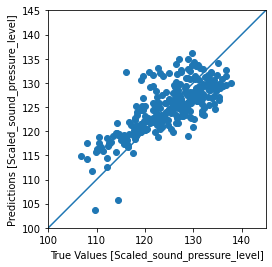

In [18]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Scaled_sound_pressure_level]')
plt.ylabel('Predictions [Scaled_sound_pressure_level]')
plt.axis('equal')
plt.axis('square')
plt.xlim([100,145])
plt.ylim([100,145])
_ = plt.plot([0, 300], [0, 300])

Según las puntuaciones y lo que podemos observar en el gráfico, vemos que el algoritmo no es muy bueno a la hora de realizar la regresión en nuestro dataset.

# Regresión basada en redes neuronales mediante TensorFlow

### Construir el modelo

Se utiliza un modelo secuencial con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

In [19]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [28]:
model = build_model()

### Descripción del modelo

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


### Entrenar el modelo

Se define la función para el entrenamiento

In [30]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

Se puede visualizar el progreso del entrenamiento del modelo usando las estadísticas almacenadas en el objeto history.

In [31]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Scaled_sound_pressure_level]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label = 'Val Error')
    plt.ylim([0,15])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Scaled_sound_pressure_level^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label = 'Val Error')
    plt.ylim([0,100])
    plt.legend()
    plt.show()

Se entrena el modelo durante 1000 épocas y se registra la precisión de entrenamiento y validación en el objeto history.


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

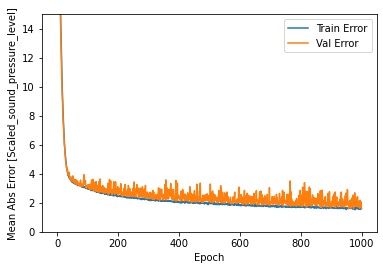

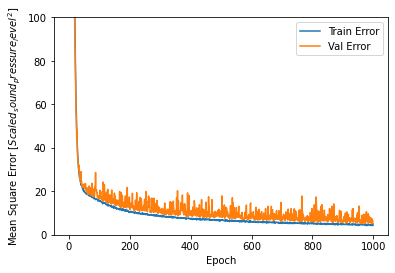

In [32]:
EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.3, verbose=0, callbacks=[PrintDot()])

plot_history(history)

Se comprueban los últimos valores del resultado del entrenamiento

In [33]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,4.194198,1.548004,4.194198,7.420480,2.176890,7.420480,995
996,4.602062,1.625667,4.602062,5.465161,1.745484,5.465161,996
997,4.794860,1.663401,4.794860,6.731515,2.082045,6.731515,997
998,4.781198,1.677221,4.781198,5.594822,1.680349,5.594822,998
999,4.417780,1.593895,4.417780,5.197334,1.631479,5.197334,999


In [34]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Scaled_sound_pressure_level".format(mae))

10/10 - 0s - loss: 3.9511 - mae: 1.4934 - mse: 3.9511
Testing set Mean Abs Error:  1.49 Scaled_sound_pressure_level


Obtenenemos un error de +/- 1.49

### Representación gráfica

Se comprueba graficamente la precisión de las predicciones (cuanto más pegado a la línea, más correcto es el valor)

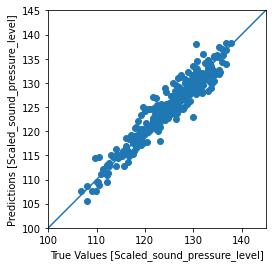

In [35]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Scaled_sound_pressure_level]')
plt.ylabel('Predictions [Scaled_sound_pressure_level]')
plt.axis('equal')
plt.axis('square')
plt.xlim([100,145])
plt.ylim([100,145])
_ = plt.plot([0, 300], [0, 300])


Se puede observar que el modelo predice con una precisión alta

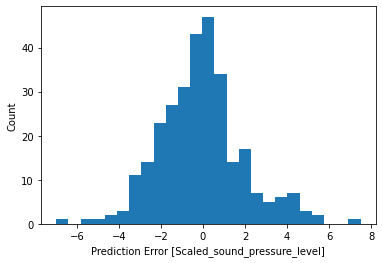

In [36]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Scaled_sound_pressure_level]")
_ = plt.ylabel("Count")

La distribución de errores sigue una función gaussiana alrededor del 0, esto indica buena precisión en el modelo.

## Conclusión
Para las 2 formas de regresión que hemos utilizado, tenemos que el algoritmo lineal nos indica un RMSE de 4.89 mientras que TensorFlow nos da un error medio absoluto de 1.49, el cual es bastante menor en comparación. Para estos datos funciona mucho mejor el método basado en redes neuronales que el del algoritmo de regresión lineal